# Deep Parametric PDE for Two Assets

Linus Wunderlich, 2020\
jww Kathrin Glau\
Research funded by EPSRC by the New Investigator Award EP/T004738/1.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LWunderlich/DeepPDE/blob/main/TwoAssetsExample/DeepParametricPDEExample.ipynb)

Example of my work in progress on the deep parametric PDE method (joint with Kathrin Glau), solving a European basket option with two underlying assets in Black-Scholes model.


## Usage: 
This notebook either loads the trained model used in the article (when load_model==True) or trains a smaller network. 
### Usage in Google Colab:
When training the network using Google Colab it is advised to use a GPU-session, which significantly speeds up the run-times. 

When you load the network, the notebook tries to automatically download the files. If this fails consider runing the notebook on your computer or loading the model from your google drive. 

### Usage as a Jupyter-Notebook
If you clone the git repository, you have automatically download the model. In this case, the download steps should be skipped and the model is directly loaded.

### Common Error Message
If you receive an error executing cell 10 reading 
> OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed: AutoGraph did convert this function. This might indicate you are trying to use an unsupported feature.

try replacing

`data_interior, data_initial = data[0]`

in cell [9] by 

``data_interior, data_initial = data``

## Problem Formulation
The option price u solves the multivariate Black-Scholes partial differential equation (formulated in the log-price with t being the time to maturity):

$
\partial_t u + 
  r  u 
  -   \left(r-\frac{\sigma_1^2}{2}\right)\partial_{x_1} u 
  - \left(r-\frac{\sigma_2^2}{2}\right)\partial_{x_2} u 
  -  \frac{\sigma_1^2}{2}  \, \partial_{x_1x_1} u  
  - \frac{\sigma_2^2}{2}  \, \partial_{x_2x_2} u  
  -  \rho \sigma_1 \sigma_2 \, \partial_{x_1x_2} u = 0
$

with the payoff as initial conditions

$
u(t=0) = \max(0, (e^{x_1} + e^{x_2})/2 - K).
$

We can reformulate any option as one with strike price $K=100$, so we keep it fixed.  



 ## Deep Parametric PDE Method

The deep parametric PDE method trains a neural network unsupervised to approximate the option price for all values of $t$, $x$ and the option parameters $r, \sigma_1, \sigma_2, \rho$ (collected in the parameter vector $\mu$):

$u_{\rm{DNN}}(t, x, \mu) \approx  u(t, x, \mu)$.

The training is unsupervised as the loss function is purely based on the PDE.

In [1]:
pip install numpy==1.19

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow import keras
from scipy.stats import norm
from numpy.polynomial.hermite import hermgauss

import matplotlib.pyplot as plt

import urllib
import os

np.random.seed(42)

## User settings
These can be changed without needing to re-train the network.

 * load_model: 
If true, the pre-trained model used in the paper will be downloaded and loaded. If false, a smaller network will be created and trained. Results will be slightly less accurate to allow for a reasonable trainings time
 * nr_samples_surface_plot: Nuber of points in each direction used for surfaces plots varying the asset prices of the underlyings
 * nr_samples_scatter_plot: Number of random points (varying time, asset price and option parameters) used for the scatter plots below.
 * nr_samples_error_calculation: Number of random points used below to approximate the $L^2$ and $L^\infty$ error of the deep parametric PDE method.

In [31]:

nr_samples_surface_plot = 21
nr_samples_scatter_plot = 1000
nr_samples_error_calculation = 10000

## Model Parameter
Re-train model after any changes.

In [4]:
# Model parameters. Re-train model after any changes.
s_min_interest = 25
s_max_interest = 150
t_min_interest = 0.5
t_max_interest = 4.

riskfree_rate_min = 0.1
riskfree_rate_max = 0.3
riskfree_rate_eval = 0.2

volatility_min = 0.1
volatility_max = 0.3
volatility1_eval = 0.1
volatility2_eval = 0.3

correlation_min = 0.2
correlation_max = 0.8
correlation_eval = 0.5

strike_price = 100.

## Neural network parameters
Settings involving the size and training of the neural network. Re-train after any changes.

In [5]:
nr_nodes_per_layer = 90
initial_learning_rate = 0.001
localisation_parameter = 1/10.

n_train = 100
nr_epochs = 601

## Internal parameters
These variables should not be changes, unless you are planing to adapt the code to new situations.

In [6]:
dimension_state = 2
dimension_parameter = 4
dimension_total = 1 + dimension_state + dimension_parameter

t_min = 0.
t_max = t_max_interest
s_max = strike_price * (1 + 3*volatility_max*t_max)
x_max = np.log(s_max)
x_min = 2*np.log(strike_price) - x_max

normalised_max = 1
normalised_min = -1

def transform_ab_to_cd(x, a, b, c, d): 
    """
    Perform a linear transformation of a scalar from the souce interval
    to the target interval.

    Keyword arguments:
    x -- scalar point(s) to transform
    a, b -- interval to transform from
    c, d -- interval to transform to 
    """
    return c + (x-a) * (d-c) / (b-a)

def transform_to_logprice(x): 
    """ Transform normalised variable to the log-price. """
    return transform_ab_to_cd(x, normalised_min, normalised_max, x_min, x_max)

def transform_to_time(t): 
    """ Transform normalised variable to the time variable. """
    return transform_ab_to_cd(t, normalised_min, normalised_max, t_min, t_max)

def normalise_logprice(x):
    """ Transform log-price to its corresponding normalised variable. """
    return transform_ab_to_cd(x, x_min, x_max, normalised_min, normalised_max)

def normalise_time(t): 
    """ Transform time to its corresponding normalised variable. """
    return transform_ab_to_cd(t, t_min, t_max, normalised_min, normalised_max)

t_min_interest_normalised = normalise_time(t_min_interest)
t_max_interest_normalised = normalise_time(t_max_interest)

diff_dx = (normalised_max-normalised_min) / (x_max-x_min) 
diff_dt = (normalised_max-normalised_min) / (t_max-t_min)

def transform_to_riskfree_rate(mu_1):
    """ Transform normalised variable to the risk-free rate. """
    return transform_ab_to_cd(mu_1, normalised_min, normalised_max,
                                    riskfree_rate_min, riskfree_rate_max)

def transform_to_volatility(mu_2):
    """ Transform normalised variable to the volatility. """
    return transform_ab_to_cd(mu_2, normalised_min, normalised_max,
                                    volatility_min, volatility_max)
    
def transform_to_correlation(mu_3):
    """ Transform normalised variable to the correlation. """
    return transform_ab_to_cd(mu_3, normalised_min, normalised_max,
                                    correlation_min, correlation_max)

def normalise_riskfree_rate(riskfree_rate):
    """ Transform risk-free rate to its corresponding normalised variable. """
    return transform_ab_to_cd(riskfree_rate,
                              riskfree_rate_min, riskfree_rate_max, 
                              normalised_min, normalised_max)
    
def normalise_volatility(volatility):
    """ Transform volatility to its corresponding normalised variable. """
    return transform_ab_to_cd( volatility, volatility_min, volatility_max,
                                            normalised_min, normalised_max)
    
def normalise_correlation(correlation):
    """ Transform correlation to its corresponding normalised variable. """
    return transform_ab_to_cd(correlation, correlation_min, correlation_max,
                                            normalised_min, normalised_max)




riskfree_rate_eval_normalised = normalise_riskfree_rate(riskfree_rate_eval)
volatility1_eval_normalised = normalise_volatility(volatility1_eval)
volatility2_eval_normalised = normalise_volatility(volatility2_eval)
correlation_eval_normalised = normalise_correlation(correlation_eval)

## Constructing the network
The following classes and functions are only necessary to construct and train the network. If the network is loaded, they can be disregarded.


In [7]:
class HighwayLayer(keras.layers.Layer):
    """ Define one layer of the highway network. """

    def __init__(self, units=50, original_input=dimension_total):
        """ Construct the layer by creating all weights and biases in keras. """ 
        super(HighwayLayer, self).__init__()
        self.units = units

        # create all weights and biases
        self.Uz = self.add_weight("Uz", shape=(original_input, self.units),
                                    initializer="random_normal", trainable=True)
        self.Ug = self.add_weight("Ug", shape=(original_input, self.units),
                                    initializer="random_normal", trainable=True)
        self.Ur = self.add_weight("Ur", shape=(original_input, self.units),
                                    initializer="random_normal", trainable=True)
        self.Uh = self.add_weight("Uh", shape=(original_input, self.units),
                                    initializer="random_normal", trainable=True)
        
        self.Wz = self.add_weight("Wz", shape=(self.units, self.units),
                                    initializer="random_normal", trainable=True)
        self.Wg = self.add_weight("Wg", shape=(self.units, self.units),
                                    initializer="random_normal", trainable=True)
        self.Wr = self.add_weight("Wr", shape=(self.units, self.units),
                                    initializer="random_normal", trainable=True)
        self.Wh = self.add_weight("Wh", shape=(self.units, self.units),
                                    initializer="random_normal", trainable=True)
        
        self.bz = self.add_weight("bz", shape=(self.units,), 
                                  initializer="random_normal", trainable=True)
        self.bg = self.add_weight("bg", shape=(self.units,), 
                                  initializer="random_normal", trainable=True)
        self.br = self.add_weight("br", shape=(self.units,), 
                                  initializer="random_normal", trainable=True)
        self.bh = self.add_weight("bh", shape=(self.units,), 
                                  initializer="random_normal", trainable=True)

    def call(self, input_combined):
        """ Returns the result of the layer calculation.
        
        Keyord arguments:
        input_combined -- Dictionary containing the original input of 
        the neural network as 'original_variable' and 
        the output of the previous layer as 'previous layer'.
        """
        previous_layer = input_combined['previous_layer']
        original_variable = input_combined['original_variable']

        # Evaluate one layer using the weights created by the constructor
        Z = tf.keras.activations.tanh(
            tf.matmul(original_variable, self.Uz)
            + tf.matmul(previous_layer,self.Wz) 
            + self.bz)
        
        G = tf.keras.activations.tanh(
            tf.matmul(original_variable, self.Ug) 
            + tf.matmul(previous_layer,self.Wg) 
            + self.bg)
        
        R = tf.keras.activations.tanh(
            tf.matmul(original_variable, self.Ur) 
            + tf.matmul(previous_layer,self.Wr) 
            + self.br)
      
        SR = tf.multiply(previous_layer, R)

        H = tf.keras.activations.tanh(
            tf.matmul(original_variable, self.Uh) 
            + tf.matmul(SR, self.Wh) 
            + self.bh)
        
        one_minus_G = tf.ones_like(G) - G

        return tf.multiply(one_minus_G, H) + tf.multiply(Z, previous_layer)

Now we create the network with three highway layers and the additional localisation:
$
10 \log( 1 + e^{0.1((e^{x_1} + e^{x_2})/2 - K e^{-rt})})
$

Note that the network is smaller than 
  the one loaded, to make the notebook more interactive.



In [8]:
def create_network(inputs):
    """ Creates the neural network by creating three highway layers and an 
    output layer. Returns the output of these layers as a tensorflow variable.

    Keyword arguments:
    inputs -- Tensorflow variable of the input layer
    """
    layer0 = keras.layers.Dense(nr_nodes_per_layer, activation="tanh")

    layer1 = HighwayLayer(units=nr_nodes_per_layer,
                          original_input=dimension_total)
    layer2 = HighwayLayer(units=nr_nodes_per_layer,
                          original_input=dimension_total)
    layer3 = HighwayLayer(units=nr_nodes_per_layer,
                          original_input=dimension_total)
    
    last_layer = keras.layers.Dense(1)

    outputs_layer0 = layer0(inputs)
    outputs_layer1 = layer1({'previous_layer': outputs_layer0, 
                             'original_variable': inputs})
    outputs_layer2 = layer2({'previous_layer': outputs_layer1, 
                             'original_variable': inputs})
    outputs_layer3 = layer3({'previous_layer': outputs_layer2, 
                             'original_variable': inputs})

    outputs_dnn = last_layer(outputs_layer3)
    
    inputs_t_normalised = inputs[:, 0:1]
    inputs_x1_normalised = inputs[:, 1:2]
    inputs_x2_normalised = inputs[:, 2:3]
    inputs_p1_normalised = inputs[:, 3:4]
    
    inputs_t = transform_to_time(inputs_t_normalised)
    inputs_x1 = transform_to_logprice(inputs_x1_normalised)
    inputs_x2 = transform_to_logprice(inputs_x2_normalised)
    inputs_s_mean = (tf.math.exp(inputs_x1) + tf.math.exp(inputs_x2))/2.
    riskfree_rate = transform_to_riskfree_rate(inputs_p1_normalised)

    localisation = tf.math.log(1+tf.math.exp(localisation_parameter * (
            inputs_s_mean - strike_price * tf.exp( - riskfree_rate * inputs_t)
              )))/localisation_parameter

    return outputs_dnn + localisation

The Keras generator creates batches of random points in the computational domain to evaluate and train the loss function at. 

It creates
 * Points in the interior $(t^i, x^i, \mu^i)$  as data_train_interior
 * Points at the payoff $(0, \hat x^i \hat \mu^i)$ as data_train_initial

In [9]:
class DPDEGenerator(keras.utils.Sequence):
    """ Create batches of random points for the network training. """

    def __init__(self, batch_size):
        """ Initialise the generator by saving the batch size. """
        self.batch_size = batch_size
      
    def __len__(self):
        """ Describes the number of points to create """
        return self.batch_size
    
    def __getitem__(self, idx):
        """ Get one batch of random points in the interior of the domain to 
        train the PDE residual and with initial time to train the initial value.
        """
        data_train_interior = np.random.uniform(
            normalised_min, normalised_max, [self.batch_size, dimension_total]) 

        t_train_initial = normalised_min * np.ones((self.batch_size, 1))
        
        s_and_p_train_initial = np.random.uniform(
            normalised_min, normalised_max,
            [self.batch_size, dimension_state + dimension_parameter])
        
        data_train_initial = np.concatenate(
            (t_train_initial, s_and_p_train_initial), axis=1)

        return [data_train_interior, data_train_initial]

The Keras model constructs the PDE-based residual for the training. 

$\mathcal{J}(u) = \mathcal{J}_{\rm{int}}(u) + \mathcal{J}_{\rm{ic}}(u)$,

with the residual of the PDE

$\mathcal{J}_{\rm{int}}(u) = 
\sum_{i=1}^N
\left(\partial_t u(t^i, x^i, \mu^i) + 
  r  u 
  -   \left(r-\frac{\sigma_1^2}{2}\right)\partial_{x_1} u (t^i, x^i, \mu^i)
  - \left(r-\frac{\sigma_2^2}{2}\right)\partial_{x_2} u (t^i, x^i, \mu^i)
  -  \frac{\sigma_1^2}{2}  \, \partial_{x_1x_1} u  (t^i, x^i, \mu^i)
  - \frac{\sigma_2^2}{2}  \, \partial_{x_2x_2} u (t^i, x^i, \mu^i) 
  -  \rho \sigma_1 \sigma_2 \, \partial_{x_1x_2} u(t^i, x^i, \mu^i) \right)^2
$

and the mean-squared error of the initial condition:

$
\mathcal{J}_{\rm{ic}}(u) =\sum_{i=1}^N \left(u(0, \hat x^i, \hat \mu^i) -  \max(0, (e^{\hat x_1^i} + e^{\hat x_2^i})/2 - K)\right)^2.
$

As all variables were normalised, they and their derivatives need to be transformed.

In [44]:
class DPDEModel(keras.Model):
    """ Create a keras model with the deep param. PDE loss function """

    def train_step(self, data):
        """ Create one optimisation stop based on the deep param. PDE loss function. """
        data_interior, data_initial = data[0]

        riskfree_rate_interior = transform_to_riskfree_rate(data_interior[:, 3:4])
        volatility1_interior = transform_to_volatility(data_interior[:, 4:5])
        volatility2_interior = transform_to_volatility(data_interior[:, 5:6])
        correlation_interior = transform_to_correlation(data_interior[:, 6:7])

        x1_initial = transform_to_logprice(data_initial[:, 1:2])
        x2_initial = transform_to_logprice(data_initial[:, 2:3])

        with tf.GradientTape() as tape:
            v_interior = self(data_interior, training=True)  # Forward pass
            v_initial = self(data_initial, training=True)  # Forward pass bdry

            gradient = K.gradients(v_interior, data_interior)[0]

            v_dt = diff_dt * gradient[:, 0:1]
            v_dx1 = diff_dx * gradient[:, 1:2]
            v_dx2 = diff_dx * gradient[:, 2:3]

            grad_v_dx1 = K.gradients(v_dx1, data_interior)[0]
            grad_v_dx2 = K.gradients(v_dx2, data_interior)[0]

            v_dx1dx1 = diff_dx * grad_v_dx1[:, 1:2]
            v_dx2dx2 = diff_dx * grad_v_dx2[:, 2:3]
            v_dx1dx2 = diff_dx * grad_v_dx1[:, 2:3]
            v_dx2dx1 = diff_dx * grad_v_dx2[:, 1:2]

            residual_interior = (
                v_dt + riskfree_rate_interior * v_interior 
                - (riskfree_rate_interior - volatility1_interior**2/2) * v_dx1
                - (riskfree_rate_interior - volatility2_interior**2/2) * v_dx2
                - 0.5 * volatility1_interior**2 * v_dx1dx1
                - 0.5 * volatility2_interior**2 * v_dx2dx2 
                - 0.5 * correlation_interior 
                    * volatility1_interior * volatility2_interior * v_dx1dx2 
                - 0.5 * correlation_interior 
                    * volatility2_interior * volatility1_interior * v_dx2dx1
                )

            s_mean_initial = 0.5 * (
                tf.math.exp(x1_initial)+tf.math.exp(x2_initial)) 
            payoff_initial = K.maximum(s_mean_initial - strike_price, 0)

            loss_interior = K.mean(K.square(residual_interior))
            loss_initial = K.mean(K.square(v_initial - payoff_initial))
            
            loss = loss_initial + loss_interior

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {"loss": loss, 
                "loss initial": loss_initial, 
                "loss interior": loss_interior}
        

## Train or load model

If load_model is set to True, the pre-trained model will be downloaded and imported. If you made any changes to the model or the architecture, you can set load_model to False and re-train. As the training takes a long time in a Google Colab notebook, a smaller version of the network will be trained.

In [11]:
%%time
load_model=False
if load_model:
    # Load model from local folder. If it is not availabe, download it.
    os.makedirs('model/variables', exist_ok=True)
    url_base = 'https://github.com/LWunderlich/DeepPDE/raw/main/TwoAssetsExample/'
    filename = 'model/saved_model.pb'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url_base + filename, filename)
        
    filename = 'model/variables/variables.data-00000-of-00001'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url_base + filename, filename)

    filename = 'model/variables/variables.index'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url_base + filename, filename)

    model = keras.models.load_model('model')   
else:
    # Create and train model from scratch. 
    inputs = keras.Input(shape=(dimension_total,))
    outputs = create_network(inputs)
    model = DPDEModel(inputs=inputs, outputs=outputs)
    batch_generator = DPDEGenerator(n_train)
    model.compile(optimizer=tf.keras.optimizers.Adam(initial_learning_rate))
    callback = tf.keras.callbacks.EarlyStopping(
        'loss', patience=50, restore_best_weights=True)
    
    model.fit(x=batch_generator, epochs=nr_epochs, steps_per_epoch=10,
                          callbacks=[callback])

2023-04-28 15:44:00.053103: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 15:44:00.078099: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff18805df20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-04-28 15:44:00.078119: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Epoch 1/601
10/10 [==============================] - 0s 34ms/step - loss: 2.8604 - loss initial: 2.3577 - loss interior: 0.5027
Epoch 2/601
10/10 [==============================] - 0s 30ms/step - loss: 2.6290 - loss initial: 2.1366 - loss interior: 0.4924
Epoch 3/601
10/10 [==============================] - 0s 29ms/step - loss: 2.5498 - loss initial: 2.1463 - loss interior: 0.4035
Epoch 4/601
10/10 [==============================] - 0s 30ms/step - loss: 2.2723 - loss initial: 1.8920 - loss interior: 0.3803
Epoch 5/601
10/10 [==============================] - 0s 49ms/step - loss: 2.1271 - loss initial: 1.7876 - loss interior: 0.3395
Epoch 6/601
10/10 [==============================] - 0s 41ms/step - loss: 1.8370 - loss initial: 1.4071 - loss interior: 0.4299
Epoch 7/601
10/10 [==============================] - 1s 52ms/step - loss: 1.8968 - loss initial: 1.5472 - loss interior: 0.3496
Epoch 8/601
10/10 [==============================] - 1s 60ms/step - loss: 1.6348 - loss initial: 1.2135 

## Functions for the evaluation
In this section, we collect some functions used to evaluate the deep parametric PDE method. This includes a reference pricer and random function evaluations.

### Exact solution
Compute the exact solution by a 1D-integral of the smoothed payoff using the methods of Bayer, et al (2018) and Pötz (2020).

Bayer, C., Siebenmorgen, M. & Tempone, R. (2018), Smoothing the payoff for efficient computation of basket option prices, Quantitative Finance 18(3), 491–505.

Pötz,C.(2020), Function approximation for option pricing and risk management,
PhD thesis, Queen Mary University of London.

In [12]:
def decompose_covariance_matrix(t, volatility1, volatility2, correlation):
    """ Decompose covariance matrix as in Lemma 3.1 of Bayer et. al (2018). """
    sigma_det = (1-correlation**2) * volatility1**2 * volatility2**2
    sigma_sum = (volatility1**2 + volatility2**2 
                  - 2*correlation*volatility1*volatility2)

    ev1 = volatility1**2 - correlation*volatility1*volatility2
    ev2 = -(volatility2**2 - correlation*volatility1*volatility2)
    ev_norm = np.sqrt(ev1**2 + ev2**2)

    eigenvalue = volatility1**2 + volatility2**2 - 2*sigma_det/sigma_sum

    v_mat = np.array([ev1, ev2]) / ev_norm
    d = t * np.array([sigma_det/sigma_sum, eigenvalue])
    return d, v_mat

def one_dimensional_exact_solution(
        t, s, riskfree_rate, volatility, strike_price):
    """ Standard Black-Scholes formula """

    d1 = (1 / (volatility*np.sqrt(t))) * (
            np.log(s/strike_price) 
            + (riskfree_rate + volatility**2/2.) * t
        )
    d2 = d1 - volatility*np.sqrt(t)
    return (norm.cdf(d1) * s 
            - norm.cdf(d2) * strike_price * np.exp(-riskfree_rate*t))

def exact_solution(
    t, s1, s2, riskfree_rate, volatility1, volatility2, correlation):
    """ Compute the option price of a European basket call option. """
    if t == 0:
        return np.maximum(0.5*(s1+s2) - strike_price, 0)

    d, v = decompose_covariance_matrix(
        t, volatility1, volatility2, correlation)
    
    beta = [0.5 * s1 * np.exp(-0.5*t*volatility1**2),
            0.5 * s2 * np.exp(-0.5*t*volatility2**2)]
    integration_points, integration_weights = hermgauss(33)

    # Transform points and weights
    integration_points = np.sqrt(2*d[1]) * integration_points.reshape(-1, 1)
    integration_weights = integration_weights.reshape(1, -1) / np.sqrt(np.pi)

    h_z = (beta[0] * np.exp(v[0]*integration_points)
           + beta[1] * np.exp(v[1]*integration_points))

    evaluation_at_integration_points = one_dimensional_exact_solution(
        t=1, s=h_z * np.exp(0.5*d[0]), 
        strike_price=np.exp(-riskfree_rate * t) * strike_price, 
        volatility=np.sqrt(d[0]), riskfree_rate=0.
        )
    
    solution = np.matmul(integration_weights, evaluation_at_integration_points)
    
    return solution[0, 0]

test_solution = exact_solution(t=4., s1=100., s2=100., riskfree_rate=0.2, 
               volatility1=0.1, volatility2=0.3, correlation=0.5)
assert(np.abs(test_solution - 55.096796282039364) < 1e-10)

In [13]:
def localisation(t, s1, s2, riskfree_rate=riskfree_rate_eval):
    """ Return the value of the localisation used in the network. """
    return 1/localisation_parameter * np.log(1 +
                    np.exp(localisation_parameter * (
                        0.5*(s1+s2) - np.exp(-riskfree_rate*t)*strike_price))
                    )

In [14]:
def get_random_points_of_interest(nr_samples, 
                    t_min_interest=t_min_interest,
                    t_max_interest=t_max_interest,
                    s_min_interest=s_min_interest,
                    s_max_interest=s_max_interest,
                    parameter_min_interest_normalised=normalised_min,
                    parameter_max_interest_normalised=normalised_max):
    """ Get a number of random points within the defined domain of interest. """
    t_sample = np.random.uniform(t_min_interest, t_max_interest, 
                                 [nr_samples, 1])
    t_sample_normalised = normalise_time(t_sample)

    s_sample = np.random.uniform(
        s_min_interest, s_max_interest, [nr_samples, dimension_state])
    s1_sample = s_sample[:, 0:1]
    s2_sample = s_sample[:, 1:2]
    x_sample_normalised = normalise_logprice(np.log(s_sample))

    parameter_sample_normalised = np.random.uniform(
        normalised_min, normalised_max, [nr_samples, dimension_parameter])
    data_normalised = np.concatenate(
        (t_sample_normalised, x_sample_normalised, parameter_sample_normalised),
        axis=1
        )

    riskfree_rate_sample = transform_to_riskfree_rate(
        parameter_sample_normalised[:, 0])
    volatility1_sample = transform_to_volatility(
        parameter_sample_normalised[:, 1])
    volatility2_sample = transform_to_volatility(
        parameter_sample_normalised[:, 2])
    correlation_sample = transform_to_correlation(
        parameter_sample_normalised[:, 3])
    
    return data_normalised, t_sample.reshape(-1), s1_sample.reshape(-1), \
            s2_sample.reshape(-1), riskfree_rate_sample, volatility1_sample, \
            volatility2_sample, correlation_sample



In [39]:

def get_points_for_plot_at_fixed_time(t_fixed=t_max,
                s_min_interest=s_min_interest, s_max_interest=s_max_interest,
                riskfree_rate_fixed=riskfree_rate_eval,
                volatility1_fixed=volatility1_eval,
                volatility2_fixed=volatility2_eval,
                correlation_fixed=correlation_eval,
                n_plot=nr_samples_surface_plot):
    """ Get the spacial and normalised values for surface plots 
    at fixed time and parameter, varying both asset prices. 
    """
    s1_plot = np.linspace(s_min_interest, s_max_interest, n_plot).reshape(-1,1)
    s2_plot = np.linspace(s_min_interest, s_max_interest, n_plot).reshape(-1,1)
    [s1_plot_mesh, s2_plot_mesh] = np.meshgrid(s1_plot, s2_plot, indexing='ij')

    x1_plot_mesh_normalised = normalise_logprice( np.log(s1_plot_mesh)).reshape(-1,1)

    x2_plot_mesh_normalised = normalise_logprice(np.log(s2_plot_mesh)).reshape(-1,1)

    t_mesh = t_fixed  * np.ones((n_plot**2, 1))
    t_mesh_normalised = normalise_time(t_mesh)

    parameter1_mesh_normalised = (normalise_riskfree_rate(riskfree_rate_fixed)   * np.ones((n_plot**2, 1)))
    parameter2_mesh_normalised = (normalise_volatility(volatility1_fixed)   * np.ones((n_plot**2, 1)))
    parameter3_mesh_normalised = (normalise_volatility(volatility2_fixed)   * np.ones((n_plot**2, 1)))
    parameter4_mesh_normalised = (normalise_correlation(correlation_fixed)   * np.ones((n_plot**2, 1)))

    x_plot_normalised = np.concatenate((t_mesh_normalised,
                                        x1_plot_mesh_normalised,
                                        x2_plot_mesh_normalised,
                                        parameter1_mesh_normalised, 
                                        parameter2_mesh_normalised,
                                        parameter3_mesh_normalised, 
                                        parameter4_mesh_normalised), axis=1)

    
    return s1_plot_mesh, s2_plot_mesh, x_plot_normalised


s1_plot_mesh, s2_plot_mesh, x_plot_normalised = \
    get_points_for_plot_at_fixed_time()

## Model evaluation
Here we evaluate the model (either loaded or trained). First we look at fixed parameters and vary the asset prices. Afterwards, we sample the whole time-state-parameter-domain to estimate the overall error.

### Plots at final time, varying the asset prices

In [16]:
DPDE_solution = model.predict(x_plot_normalised).reshape(
    nr_samples_surface_plot, nr_samples_surface_plot)

exact_solution_evaluated = [exact_solution(t=t_max, s1=s1[0], s2=s2[0], 
                                riskfree_rate=riskfree_rate_eval, 
                                volatility1=volatility1_eval, 
                                volatility2=volatility2_eval,
                                correlation=correlation_eval)
                  for s1, s2 in zip(
                      s1_plot_mesh.reshape(-1, 1), s2_plot_mesh.reshape(-1, 1))
                  
                  ]
exact_solution_evaluated = np.array(exact_solution_evaluated)
exact_solution_evaluated = exact_solution_evaluated.reshape(
    nr_samples_surface_plot, nr_samples_surface_plot)

localisation_plot = localisation(4., s1_plot_mesh, s2_plot_mesh, riskfree_rate_eval)


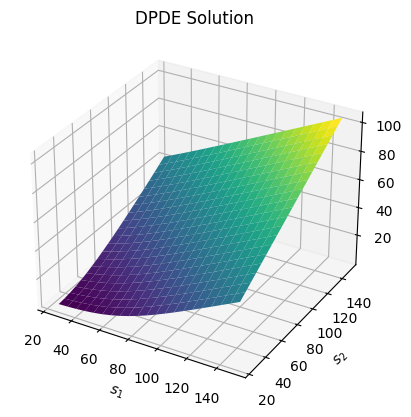

In [17]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, DPDE_solution, cmap='viridis')
ax.set_title('DPDE Solution')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

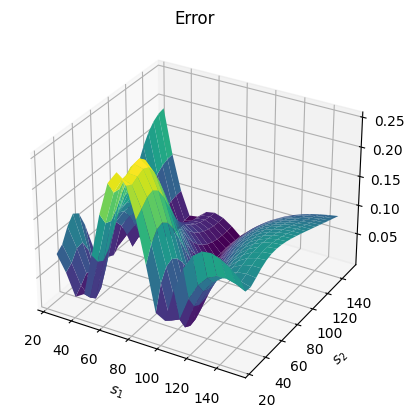

In [18]:
fig = plt.figure()
ax = plt.axes(projection='3d')

error = np.abs(DPDE_solution - exact_solution_evaluated)
ax.plot_surface(s1_plot_mesh, s2_plot_mesh, error, cmap='viridis')
ax.set_title('Error')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

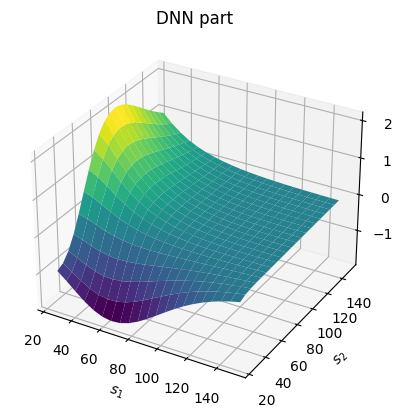

In [19]:
fig = plt.figure()
ax = plt.axes(projection='3d')

dnn_part = DPDE_solution - localisation_plot
ax.plot_surface(s1_plot_mesh, s2_plot_mesh, dnn_part, cmap='viridis')
ax.set_title('DNN part')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

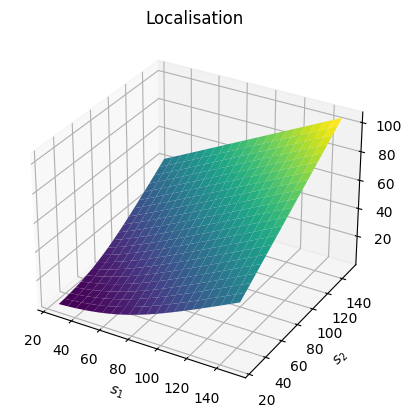

In [20]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, localisation_plot, cmap='viridis')
ax.set_title('Localisation')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

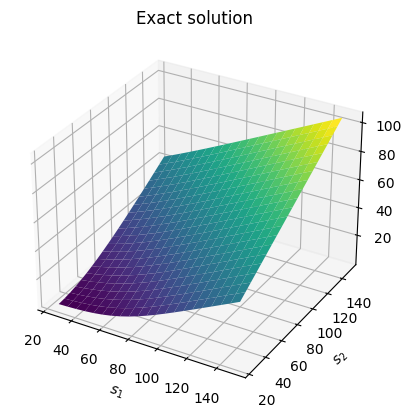

In [21]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, exact_solution_evaluated, cmap='viridis')
ax.set_title('Exact solution')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

### Scatter plots, varying time, asset prices and parameters

In [22]:
data_samples, t_samples, s1_samples, s2_samples, riskfree_rate_samples, \
  volatility1_samples, volatility2_samples, correlation_samples = \
              get_random_points_of_interest(nr_samples_scatter_plot)

In [23]:
print('Predict {} values and measure the time:'.format(nr_samples_scatter_plot))
%time DPDE_solution = model.predict(data_samples)

Predict 1000 values and measure the time:
CPU times: user 126 ms, sys: 13.3 ms, total: 140 ms
Wall time: 202 ms


In [24]:
exact_solution_evaluated = [exact_solution(t=t, s1=s1, s2=s2,
                                  riskfree_rate=riskfree_rate,
                                  volatility1=volatility1,
                                  volatility2=volatility2,
                                  correlation=correlation
                                  ) 
                  for t, s1, s2, riskfree_rate, volatility1, volatility2,
                      correlation 
                  in zip(t_samples, s1_samples, s2_samples, riskfree_rate_samples, 
                          volatility1_samples, volatility2_samples,
                          correlation_samples)]

exact_solution_evaluated = np.array(exact_solution_evaluated).reshape(-1,1)

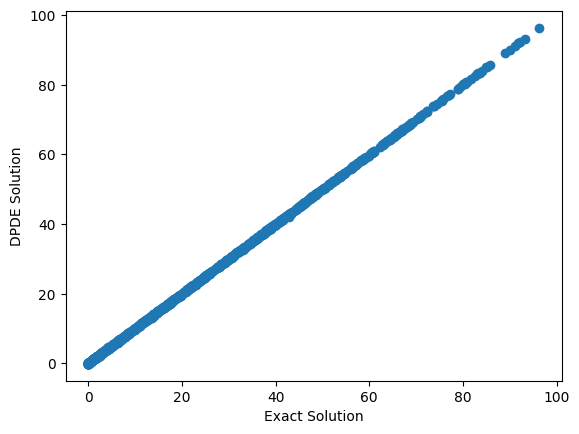

In [25]:
plt.scatter(exact_solution_evaluated, DPDE_solution)
plt.xlabel('Exact Solution')
plt.ylabel('DPDE Solution')
plt.show()

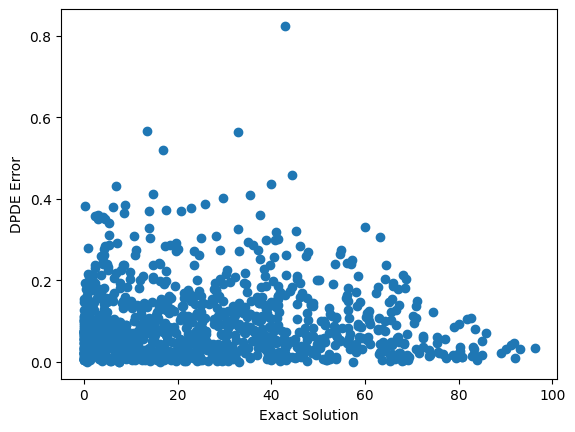

In [26]:
plt.scatter(exact_solution_evaluated, 
            np.abs(exact_solution_evaluated - DPDE_solution))
plt.xlabel('Exact Solution')
plt.ylabel('DPDE Error')
plt.show()

### Estimate the error based on random points

In [27]:
data_samples, t_samples, s1_samples, s2_samples, riskfree_rate_samples, \
  volatility1_samples, volatility2_samples, correlation_samples = \
              get_random_points_of_interest(nr_samples_error_calculation)

In [28]:
print('Predict {} values and measure the time:'.format(nr_samples_error_calculation))
%time DPDE_solution = model.predict(data_samples)

Predict 10000 values and measure the time:
CPU times: user 709 ms, sys: 91.6 ms, total: 800 ms
Wall time: 512 ms


In [29]:
exact_solution_evaluated = [exact_solution(t=t, s1=s1, s2=s2, 
                                  riskfree_rate=riskfree_rate,
                                  volatility1=volatility1,
                                  volatility2=volatility2,
                                  correlation=correlation) 
            for t, s1, s2, riskfree_rate, volatility1, volatility2, correlation 
            in zip(t_samples, s1_samples, s2_samples, riskfree_rate_samples, 
                    volatility1_samples, volatility2_samples,
                    correlation_samples)]

exact_solution_evaluated = np.array(exact_solution_evaluated).reshape(-1, 1)

In [30]:
print('Estimated MSE Error:')
print(np.sqrt(np.mean(np.square(exact_solution_evaluated - DPDE_solution))))

print('Relative Error to L2 Norm in %:')
print(np.sqrt(np.mean(np.square(exact_solution_evaluated - DPDE_solution))) 
        / np.sqrt(np.mean(np.square(exact_solution_evaluated)))*100)

print('Maximal Error:')
print(np.max(exact_solution_evaluated - DPDE_solution))

Estimated MSE Error:
0.12519699410318008
Relative Error to L2 Norm in %:
0.3486649618454658
Maximal Error:
0.7888941739442519
